In [1]:
sc

#Part I

In [2]:
import json
import numpy as np
def parse(a):
    time = np.array(a['data'][0:4757])
    flux = np.array(a['data'][4757:])
    ind = a['id']
    return (time, flux, ind)
lcbb = sc.textFile("s3n://stat-37601/lightcurves.json",minPartitions=1000).map(lambda x: parse(json.loads(x))[1:])
lc = lcbb.filter(lambda x: len(x[0]) == 4757)

###I decided to replace the NaNs by interpolation.

In [3]:
gap = 0.0204;
N = 4757;
sz = (N-1)/2;
u = np.arange(-gap*sz, gap*(sz+1), gap, dtype=np.float64)

def kernel_epa(u):
    w = (abs(u) <= 1) * (1 - u*u)
    return w

#h = 1 #bandwidth
#w = kernel_epa(u/h)
#const = np.convolve(w, np.ones(len(u), dtype=np.float64), "same")
hs = [.025,.05,.1,.5,1,1.5,2]
ws = {h:kernel_epa(u/h) for h in hs}
consts = {key:np.convolve(ws[key], np.ones(len(u), dtype=np.float64), "same") for key in hs}

def interpolate(A):
    ok = -np.isnan(A)
    xp = ok.ravel().nonzero()[0]
    fp = A[-np.isnan(A)]
    x  = np.isnan(A).ravel().nonzero()[0]
    A[np.isnan(A)] = np.interp(x, xp, fp)
    return A


def yhat_comp(flux,w,const):
    flux = interpolate(flux)
    yhat = np.convolve(w, flux , "same") / const
    return yhat

def risk_comp(flux,yy,w,const):
    #notbad = np.where(np.invert(np.isnan(flux)))
    flux = interpolate(flux)
    #yhat = yhat_comp(flux)
    ll = 1/const
    ss = np.ones(len(ll)) - ll
    difrat = ((flux-yy)/ss)**2
    return float(np.sum(difrat)/float(len(u))**2)

def yhat2(flux):
    #Computes the yhat for the optimal bandwith
    err = float('Inf')
    yhat = None
    for i in hs:
        w = ws[i]
        const = consts[i]
        yhatp = yhat_comp(flux,w,const)
        aa = risk_comp(flux,yhatp,w,const)
        if aa < err:
            err = aa
            yhat = yhatp
            idx = i
    return yhat

#print yhat2(lcsub.take(2)[0]), yhat2(lcsub.take(10)[8]), yhat2(lcsub.take(10)[9]) 

In [4]:
def sighat(vv):
    #computes sigma hat for a vector using MAD
    mm = np.median(vv)
    vv2 = np.absolute(vv-mm)
    return np.median(vv2)*1.4826

def stdresid(flux):
    #Computes reisd, standardizes resid using MAD
    #notbad = np.where(np.invert(np.isnan(flux)))
    vv = np.array(flux-yhat2(flux))
    ss = sighat(vv)
    return (vv - np.mean(vv))/ss

def threshold(vv):
    #standardizes vv and thresholds it
    vec = stdresid(vv)
    thresh = np.sqrt(2*np.log(len(vec)))
    out=[]
    for v in vec:
        if v <=-thresh:
            out.append(v)
        else:
            out.append(0)
    return out

In [5]:
threshlc = lc.map(lambda x:(threshold(x[0]),x[1]))
normlc = threshlc.map(lambda x:(x[1],np.linalg.norm(x[0],1)))
#normlc contains the label and norm of each thresholded light curve

In [87]:
#bignorms = normlc.filter(lambda x:x[1]>1000).collect()
normlc2 = normlc.collect()

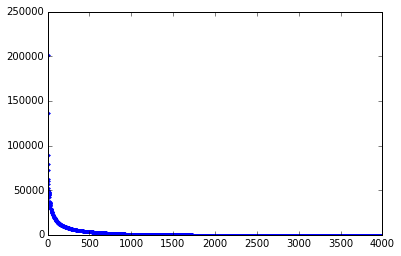

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
aa = [x[1] for x in normlc2]
plt.plot(np.sort(aa)[::-1][:4000], '.')

###Above I've plotted the top 4000 norms in decreasing order. We see that there is large variability in the post standardized light curve norms.

###Below I also have some of the names together with the norms for the largest norm star systemds.

In [89]:
sorts = np.array(normlc2)
norms = [float(x[1]) for x in sorts]
inds = np.argsort(norms)
sorts = sorts[inds][::-1]
print sorts[:11]

[[u'kplr011199438-2012277125453_llc' u'201050.264723']
 [u'kplr009641031-2012277125453_llc' u'136117.120525']
 [u'kplr004544587-2012277125453_llc' u'89063.6803273']
 [u'kplr006525196-2012277125453_llc' u'79676.0815379']
 [u'kplr012418816-2012277125453_llc' u'72202.2480145']
 [u'kplr005444392-2012277125453_llc' u'62887.4109843']
 [u'kplr003241619-2012277125453_llc' u'60754.5924679']
 [u'kplr005513861-2012277125453_llc' u'57108.7918765']
 [u'kplr009020426-2012277125453_llc' u'52029.0662438']
 [u'kplr008552540-2012277125453_llc' u'50382.1951061']
 [u'kplr010191056-2012277125453_llc' u'49551.2563887']]


In [91]:
vec = lc.filter(lambda x: x[1]=='kplr011199438-2012277125453_llc').take(1)[0][0]

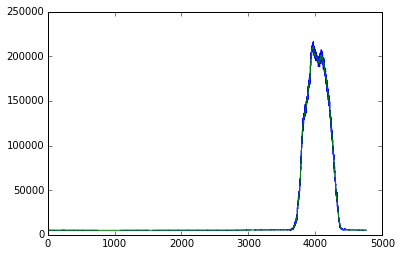

In [92]:
plt.plot(vec)
plt.plot(yhat2(vec))

###It seems to be that the largest star system had a supernova-like occurence: there is a time where the norm is much larger than the rest of the time period, as seen above.

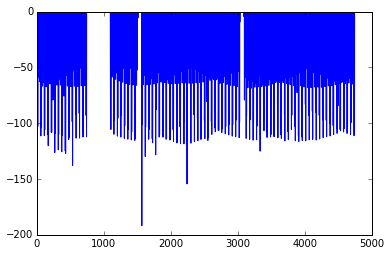

In [77]:
vec = lc.filter(lambda x: x[1]=='kplr008552540-2012277125453_llc').take(1)[0][0]
plt.plot(threshold(vec))
#plt.plot(vec[:1000])
#plt.plot(yhat2(vec)[:1000])

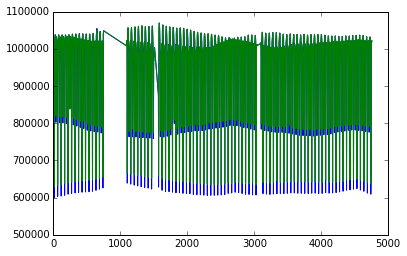

In [79]:
plt.plot(vec)
plt.plot(yhat2(vec))

###However, for many other large norm stars, we see the type of behavior we are looking for, as seen above.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import urllib2

def prcurve(ranking, positives, curvetitle):
    """
    Display the precision-recall curve and 
    compute the area under it. (See `prcurve_1` and `prcurve_2`.)
    """

    # Change ID formats
    mapping = pickle.load(urllib2.urlopen("https://s3.amazonaws.com/ml-lightcurves-q14/mapp.pickle"))
    as_dict = dict([(y, x) for (x, y) in mapping])
    ranking = [as_dict.get(x, None) for x in ranking]
    as_dict = None
    mapping = None

    # Precision-recall
    precision = []
    recall = []
    count = 0.0
    N = len(positives)
    for i, ID in enumerate(ranking):
        if ID in positives:
            count += 1.0
            precision.append( count/(i+1) )
            recall.append( count/ N )
        if count == N:
            break

    a = np.array(precision, dtype=np.float32)
    area = np.sum(a / N)

    plt.plot(recall, precision, '-r', linewidth=2)
    plt.xlabel('recall', fontsize=15)
    plt.ylabel('precision',fontsize=15)
    plt.xlim((-0.01,1.01))
    plt.title('{} area = {}'.format(curvetitle, area), fontsize=15)
    plt.show()

    return area

def prcurve_1(ranking):
    """
    PART I: detect confirmed or eclipsing binary stars
    """
    conf_and_eb_id = [int(i) for i in 
                      urllib2.urlopen('https://s3.amazonaws.com/ml-lightcurves-q14/conf_and_eb_id.txt')]
    conf_cand_eb_id = [int(i) for i in
                       urllib2.urlopen('https://s3.amazonaws.com/ml-lightcurves-q14/conf_cand_eb_id.txt')]
    
    return (prcurve(ranking, conf_and_eb_id, "conf+eb"),
            prcurve(ranking, conf_cand_eb_id, "conf&cand+eb"))

def prcurve_2(ranking):
    """
    PART II: detect confirmed stars
    """
    conf_id = [int(i) for i in 
               urllib2.urlopen('https://s3.amazonaws.com/ml-lightcurves-q14/conf_id.txt')]
    conf_and_cand_id = [int(i) for i in 
                        urllib2.urlopen('https://s3.amazonaws.com/ml-lightcurves-q14/conf_and_cand_id.txt')]
    
    return (prcurve(ranking, conf_id, "conf"),
            prcurve(ranking, conf_and_cand_id, "conf&cand"))

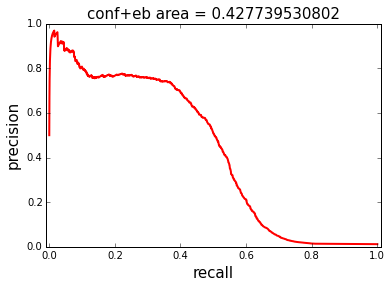

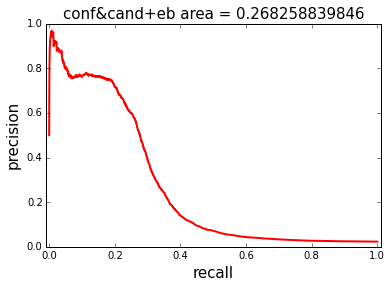

(0.42773953, 0.26825884)

In [90]:
results = [x[0] for x in sorts]
prcurve_1(results)

In [6]:
def findmins(flux):
    """
    finds mins of flux standardized by a kernel estimate and returns them
    """
    vv = stdresid(flux)
    dd = np.diff(vv)
    ispos = np.array([float(x>=0) for x in dd]+[0])
    ll = []
    for i in range(len(vv)-1):
        if ispos[i+1]-ispos[i]>0:
            ll.append(i+1)
    bb =  [int(x) for x in ll]
    return np.array(vv)[bb]

In [143]:
vv = np.array( lc.take(14)[2][0] - yhat2(lc.take(14)[2][0]) )
dd = np.diff(vv)
#print dd
ispos = np.array([float(x>=0) for x in dd]+[0])
#print ispos
ll = []
for i in range(len(vv)-1):
    if ispos[i+1]-ispos[i]>0:
        ll.append(i+1)
bb =  [int(x) for x in ll]
#print np.array(vv)[bb]
print findmins(lc.take(14)[7][0])

[          nan  158.08011082   53.97857461 ...,   31.09526419  -12.06756619
  -75.23625974]
[ 0.  1.  1. ...,  0.  0.  0.]
[-104.55219253  -43.26297603 -192.32996703 ...,   -1.45211376  -69.25080562
  -63.89300652]
[-29.80363793 -41.0203894  -14.06368758 ...,  -7.15741419 -12.71675711
 -10.14359646]
None


In [ ]:
minlcs = lc.map(lambda x:(findmins(x[0]),x[1]))
normlc = minlcs.map( lambda x:(x[1],np.var( x[0] )) ).collect()

In [ ]:
sorts = np.array(minlcs)
norms = [float(x[1]) for x in sorts]
inds = np.argsort(norms)
sorts = sorts[inds][::-1]